# Siamese Network
Network for a Face Recognition System

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Dataset

## Utility Functions

In [2]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

## Prepare Data

In [3]:
# Get the data directory paths
faces = '../input/olivetti/olivetti_faces.npy'
faces_targets = '../input/olivetti/olivetti_faces_target.npy'

In [4]:
# Load the images and labels
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [5]:
target_shape = face_images[0].shape

In [6]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [7]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

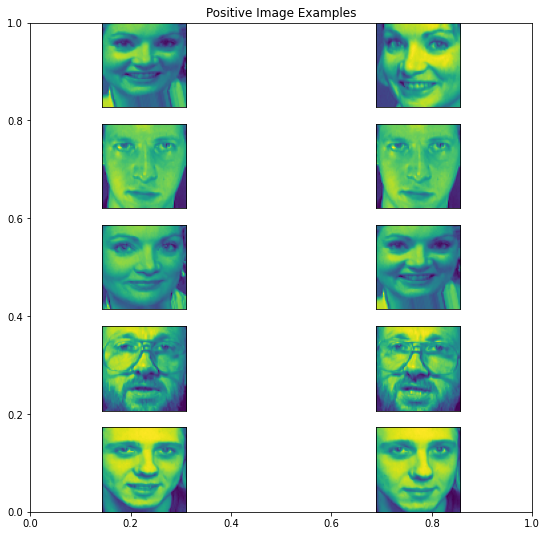

In [8]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

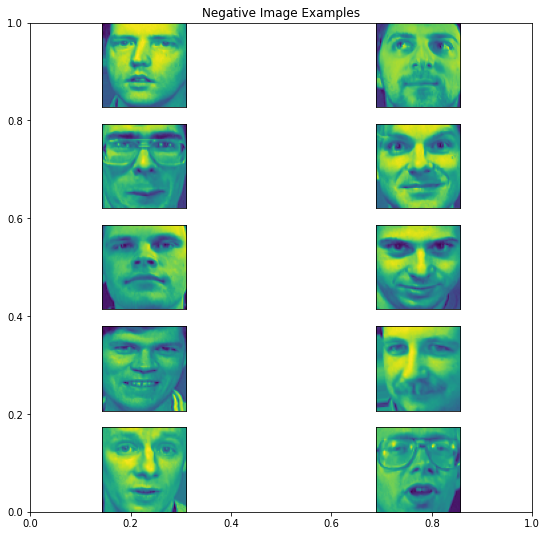

In [9]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

# Network Architecture

## Embedding Layer

In [10]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

2022-01-27 08:30:02.772388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 08:30:02.907546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 08:30:02.908319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 08:30:02.909473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Siamese Network

In [11]:
import tensorflow.keras.backend as K

In [12]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [13]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [14]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

# Training

In [15]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

2022-01-27 08:30:06.568940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-01-27 08:30:08.291742: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 9s 118ms/step - loss: 0.6793 - accuracy: 0.5047 - val_loss: 0.6399 - val_accuracy: 0.5188
Epoch 2/150
10/10 [==============================] - 1s 65ms/step - loss: 0.6521 - accuracy: 0.5047 - val_loss: 0.6274 - val_accuracy: 0.5312
Epoch 3/150
10/10 [==============================] - 1s 67ms/step - loss: 0.6308 - accuracy: 0.5047 - val_loss: 0.6123 - val_accuracy: 0.5188
Epoch 4/150
10/10 [==============================] - 1s 65ms/step - loss: 0.6121 - accuracy: 0.5063 - val_loss: 0.6267 - val_accuracy: 0.5437
Epoch 5/150
10/10 [==============================] - 1s 64ms/step - loss: 0.6543 - accuracy: 0.5094 - val_loss: 0.6631 - val_accuracy: 0.6062
Epoch 6/150
10/10 [==============================] - 1s 64ms/step - loss: 0.6680 - accuracy: 0.5719 - val_loss: 0.6708 - val_accuracy: 0.7125
Epoch 7/150
10/10 [==============================] - 1s 64ms/step - loss: 0.6785 - accuracy: 0.6109 - val_loss: 0.6876 - val_accuracy: 0.5813
Epoch 8/150
10/10

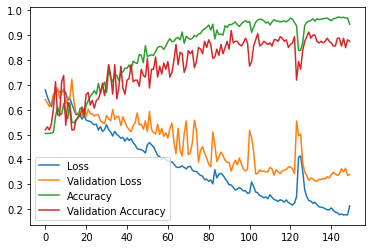

In [16]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

# Testing

In [17]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 1

In [18]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

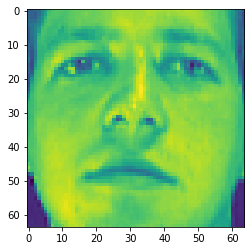

In [19]:
plt.imshow(test_image)

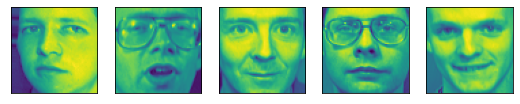

In [20]:
test_visualize(compare_images)

In [21]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [22]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [23]:
print(score)

[[0.7926489 ]
 [0.5802973 ]
 [0.00151463]
 [0.00240386]
 [0.00457218]]


## Test 2

In [24]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

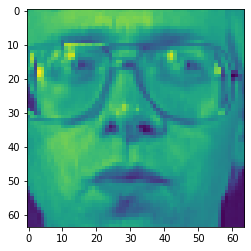

In [25]:
plt.imshow(test_image)

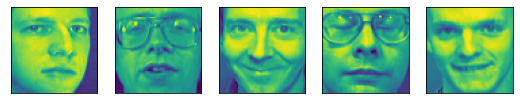

In [26]:
test_visualize(compare_images)

In [27]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [28]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [29]:
print(score)

[[0.58032215]
 [0.79100263]
 [0.00134922]
 [0.00216706]
 [0.0042368 ]]
